0.5273656621130207


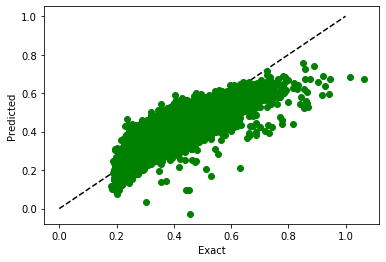

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def NARMA10(N):
    u = np.random.random(N+50)*0.5
    y = np.zeros(N+50)
    for k in range(10,N+50):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return u[50:], y[50:]

def MG_func(x, J, gamma, eta, p):
    return eta*(x + gamma*J) / (1 + np.power( x + gamma*J, p))


def MSE(y,d):
    return np.square(np.subtract(y,d)).mean()

def NRMSE(y,d):
    var = np.var(d)
    return np.sqrt(np.square(np.subtract(y,d)).mean()/var)

class Single_Node_Reservoir:
    def __init__(self, Nin, Nvirt, Nout, theta):
        self.Nin = Nin
        self.Nvirt = Nvirt
        self.Nout = Nout
        self.theta = theta
        self.m0 = 0.1
        self.M = 2*self.m0*(np.random.randint(0,2, (Nvirt,Nin))-0.5)
        self.W = np.zeros( (Nvirt,Nout))

    def gen_signal(self, u):
        '''
        Function to generate the reservoir signal from an input u
        '''
        Ns = len(u)
        u = u.reshape((Ns,self.Nin))
        J = np.zeros((Ns, self.Nvirt))
        S = np.zeros((Ns, self.Nvirt))

        Sigma = np.exp(-self.theta)
        gamma = 0.001
        eta = 0.45
        P = 1

        for k in range(Ns):
            J[k] = np.matmul( self.M, u[k])

            S[k,0] = S[k-1,self.Nvirt-1] * Sigma + (1.0 - Sigma)*MG_func( S[k-1,0], J[k,0], gamma, eta, P)
            for i in range(1,self.Nvirt):
                S[k,i] = S[k,i-1] * Sigma + (1.0 - Sigma)*MG_func( S[k-1,i], J[k,i], gamma, eta, P)



        return S

    def train(self, S, Y, l):
        # Y = S * W^T
        # S^T * Y = S^T * S * W^T
        # W^T = (S^T*S + \lambda^2 I)^-1 * S^T * Y
        STY = np.matmul(S.T, Y)
        STS = np.matmul(S.T, S) + l**2*np.eye(S.shape[1])
        STS_inv = np.linalg.pinv(STS)
        self.Wout = np.matmul(STS_inv, STY)


    def forward(self, xb):
        return np.dot(xb, self.Wout)




net = Single_Node_Reservoir(1, 400, 1, 0.2)

Ns = 10000
u, d = NARMA10(Ns)
u.reshape((Ns,1))
d.reshape((Ns,1))

S = net.gen_signal(u)
net.train(S, d, 0.0)


pred = net.forward(S)
error = NRMSE(pred, d)
print(error)

plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(d, pred,'go')
plt.ylabel('Predicted')
plt.xlabel('Exact')
plt.show()